In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from tabulate import tabulate
from helpers.util_functions import normalise_value

from moral.ppo import PPO, TrajectoryDataset, update_policy
from envs.gym_wrapper import *
import random

from quality_metrics.validity_measures import validity_all as validity
from quality_metrics.validity_measures import validity_single, validity_single_partial
from quality_metrics.distance_measures import distance_all as distance
from quality_metrics.distance_measures import distance_single
from quality_metrics.diversity_measures import diversity_all as diversity
from quality_metrics.diversity_measures import diversity_single, distance_subtrajectories
from quality_metrics.critical_state_measures import critical_state_all as critical_state
from quality_metrics.critical_state_measures import critical_state_single
from quality_metrics.realisticness_measures import realisticness_all as realisticness
from quality_metrics.realisticness_measures import realisticness_single_partial
from quality_metrics.sparsity_measure import sparsity_all as sparsity
from quality_metrics.sparsity_measure import sparsitiy_single_partial

# pearson correlation
from scipy.stats import pearsonr, spearmanr

c:\Users\janwe\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
class config:
    env_id= 'randomized_v2'
    env_steps= 8e6
    batchsize_ppo= 12
    n_queries= 50
    preference_noise= 0
    n_workers= 1
    lr_ppo= 3e-4
    entropy_reg= 0.25
    gamma= 0.999
    epsilon= 0.1
    ppo_epochs= 5
    max_steps = 75
    base_path = '.\datasets\\100mstep\\'
    measure_statistics = True
    num_runs = 30
    criteria = ['validity', 'diversity', 'proximity', 'critical_state', 'realisticness', 'sparsity']
    # criteria = ['baseline']
    # criteria = ['validity']
    cf_method = 'mcts' # 'mcts' or 'step'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# Load normalisation

with open('..\..\interpretability\\normalisation_values.pkl', 'rb') as f:
    normalisation = pkl.load(f)

weights = pkl.load(open('..\..\quality_metrics\\1000weights.pkl', 'rb'))

random.seed(4)
seed_env = random.randint(0, 100000)
torch.manual_seed(seed_env)
np.random.seed(seed_env)

# Create Environment
vec_env = VecEnv(config.env_id, config.n_workers, seed=seed_env)
states = vec_env.reset()
states_tensor = torch.tensor(states).float().to(device)

# Fetch Shapes
n_actions = vec_env.action_space.n
obs_shape = vec_env.observation_space.shape
state_shape = obs_shape[:-1]
in_channels = obs_shape[-1]

ppo = PPO(state_shape=state_shape, in_channels=in_channels, n_actions=n_actions).to(device)
ppo.load_state_dict(torch.load('..\..\saved_models/ppo_airl_v2_[1,10].pt', map_location=torch.device('cpu')))
# ppo.load_state_dict(torch.load('..\..\saved_models/ppo_airl_v2_[1,10]_new.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

# 1-step

In [82]:
# load the trajectories'a_ending_prob0.05',
# iterate over folders in 'datasets\ablations_norm\mcts'

ablations = []

for folder in os.listdir('..\..\datasets\\ablations_norm\step'):
    ablations.append(folder)

cfs = {}
orgs = {}
starts = {}
for ablation in ablations:
    with open('..\..\datasets\\ablations_norm\\step\\' + ablation + '\cf_trajectories.pkl', 'rb') as f:
        cfs[ablation] = pkl.load(f)
    with open('..\..\datasets\\ablations_norm\\step\\' + ablation + '\org_trajectories.pkl', 'rb') as f:
        orgs[ablation] = pkl.load(f)
    with open('..\..\datasets\\ablations_norm\\step\\' + ablation + '\statistics\start_points.pkl', 'rb') as f:
        starts[ablation] = pkl.load(f)

In [83]:
vals_all, proxs_all, divs_all, crits_all, spars_all, reals_all, qcs_all = {}, {}, {}, {}, {}, {}, {}

for ablation in ablations:
    vals, proxs, divs, crits, spars, reals, qcs = [], [], [], [], [], [], []
    prev_org_trajs, prev_cf_trajs, prev_starts = [], [], []
    for i in range(len(orgs[ablation])):
            weight = weights[i]
            val = validity_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
            val = normalise_value(val, normalisation, 'validity') * weight['validity']
            vals.append(val)
            prox = distance_subtrajectories(orgs[ablation][i][0], cfs[ablation][i][0])
            prox = normalise_value(prox, normalisation, 'proximity') * weight['proximity']
            proxs.append(prox)
            div = diversity_single(orgs[ablation][i][0], cfs[ablation][i][0], starts[ablation][i], prev_org_trajs, prev_cf_trajs, prev_starts)
            div = normalise_value(div, normalisation, 'diversity') * weight['diversity']
            divs.append(div)
            crit = critical_state_single(ppo, orgs[ablation][i][0]['states'][0])
            crit = normalise_value(crit, normalisation, 'critical_state') * weight['critical_state']
            crits.append(crit)
            spar = sparsitiy_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
            spar = normalise_value(spar, normalisation, 'sparsity') * weight['sparsity']
            spars.append(spar)
            real = realisticness_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
            # if real > 10:
            #     org = orgs[ablation]}[i][0]
            #     cf = cfs[ablation]}[i][0]
            #     a=0
            real = normalise_value(real, normalisation, 'realisticness') * weight['realisticness']
            reals.append(real)
            qc = val + prox + div + crit + spar + real
            qcs.append(qc)

            prev_org_trajs.append(orgs[ablation][i][0])
            prev_cf_trajs.append(cfs[ablation][i][0])
            prev_starts.append(starts[ablation][i])

    vals_all[ablation] = vals
    proxs_all[ablation] = proxs
    divs_all[ablation] = divs
    crits_all[ablation] = crits
    spars_all[ablation] = spars
    reals_all[ablation] = reals
    qcs_all[ablation] = qcs

In [102]:
# add load
ablation = 'a_ending_prob0.5_follow_policy0'
ablations.append(ablation)

with open('..\..\datasets\\ablations_norm\\step\\' + ablation + '\cf_trajectories.pkl', 'rb') as f:
    cfs[ablation] = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\step\\' + ablation + '\org_trajectories.pkl', 'rb') as f:
    orgs[ablation] = pkl.load(f)
with open('..\..\datasets\\ablations_norm\\step\\' + ablation + '\statistics\start_points.pkl', 'rb') as f:
    starts[ablation] = pkl.load(f)

vals, proxs, divs, crits, spars, reals, qcs = [], [], [], [], [], [], []
prev_org_trajs, prev_cf_trajs, prev_starts = [], [], []
for i in range(len(orgs[ablation])):
        weight = weights[i]
        val = validity_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
        val = normalise_value(val, normalisation, 'validity') * weight['validity']
        vals.append(val)
        prox = distance_subtrajectories(orgs[ablation][i][0], cfs[ablation][i][0])
        prox = normalise_value(prox, normalisation, 'proximity') * weight['proximity']
        proxs.append(prox)
        div = diversity_single(orgs[ablation][i][0], cfs[ablation][i][0], starts[ablation][i], prev_org_trajs, prev_cf_trajs, prev_starts)
        div = normalise_value(div, normalisation, 'diversity') * weight['diversity']
        divs.append(div)
        crit = critical_state_single(ppo, orgs[ablation][i][0]['states'][0])
        crit = normalise_value(crit, normalisation, 'critical_state') * weight['critical_state']
        crits.append(crit)
        spar = sparsitiy_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
        spar = normalise_value(spar, normalisation, 'sparsity') * weight['sparsity']
        spars.append(spar)
        real = realisticness_single_partial(orgs[ablation][i][0], cfs[ablation][i][0])
        # if real > 10:
        #     org = orgs[ablation]}[i][0]
        #     cf = cfs[ablation]}[i][0]
        #     a=0
        real = normalise_value(real, normalisation, 'realisticness') * weight['realisticness']
        reals.append(real)
        qc = val + prox + div + crit + spar + real
        qcs.append(qc)

        prev_org_trajs.append(orgs[ablation][i][0])
        prev_cf_trajs.append(cfs[ablation][i][0])
        prev_starts.append(starts[ablation][i])

vals_all[ablation] = vals
proxs_all[ablation] = proxs
divs_all[ablation] = divs
crits_all[ablation] = crits
spars_all[ablation] = spars
reals_all[ablation] = reals
qcs_all[ablation] = qcs

In [84]:
import scipy.stats as stats
# test statstical significance

means = {}
p_values = {}
stds = {}
for ablation in ablations:
    means[ablation] = np.mean(qcs_all[ablation])
    p_values[ablation] = stats.ttest_ind(qcs_all[ablation], qcs_all['a'], equal_var=False)[1]
    stds[ablation] = np.std(qcs_all[ablation])
    if len(qcs_all[ablation]) != 100 and len(qcs_all[ablation]) != 200:
        print(ablation, len(qcs_all[ablation]))

In [85]:
# Show in a table
table = [
    ['Ablation', 'Mean', 'p-value'],
]
for ablation in ablations:
    table.append([ablation, means[ablation], p_values[ablation]])
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════════════════════╤═════════╤═════════════╕
│ Ablation                          │    Mean │     p-value │
╞═══════════════════════════════════╪═════════╪═════════════╡
│ a                                 │ 1.31856 │ 1           │
├───────────────────────────────────┼─────────┼─────────────┤
│ a_ending_meeting1                 │ 1.33839 │ 0.721533    │
├───────────────────────────────────┼─────────┼─────────────┤
│ a_ending_meeting1_follow_policy0  │ 1.11442 │ 0.000245702 │
├───────────────────────────────────┼─────────┼─────────────┤
│ a_ending_prob0.05                 │ 1.33603 │ 0.753627    │
├───────────────────────────────────┼─────────┼─────────────┤
│ a_ending_prob0.05_follow_policy0  │ 1.39624 │ 0.168313    │
├───────────────────────────────────┼─────────┼─────────────┤
│ a_ending_prob0.05_num_deviations2 │ 1.33791 │ 0.724003    │
├───────────────────────────────────┼─────────┼─────────────┤
│ a_ending_prob0.05_num_deviations3 │ 1.33621 │ 0.79413     │
├───────

In [108]:
table = [
    ['Ablation', 'Validity', 'Proximity', 'Diversity', 'Critical State', 'Realisticness', 'Sparsity', 'Weighted Sum'],
]
for ablation in ablations:
    # if '_num_deviations' not in ablation:
    table.append([ablation, np.mean(vals_all[ablation]), np.mean(proxs_all[ablation]), np.mean(divs_all[ablation]), np.mean(crits_all[ablation]), np.mean(reals_all[ablation]), np.mean(spars_all[ablation]), np.mean(qcs_all[ablation])])

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═══════════════════════════════════╤════════════╤═════════════╤═════════════╤══════════════════╤═════════════════╤════════════╤════════════════╕
│ Ablation                          │   Validity │   Proximity │   Diversity │   Critical State │   Realisticness │   Sparsity │   Weighted Sum │
╞═══════════════════════════════════╪════════════╪═════════════╪═════════════╪══════════════════╪═════════════════╪════════════╪════════════════╡
│ a                                 │   0.245168 │   0.13365   │   0.0730741 │         0.252071 │        0.208403 │   0.40619  │        1.31856 │
├───────────────────────────────────┼────────────┼─────────────┼─────────────┼──────────────────┼─────────────────┼────────────┼────────────────┤
│ a_ending_meeting1                 │   0.235572 │   0.138862  │   0.0670742 │         0.224601 │        0.218976 │   0.453303 │        1.33839 │
├───────────────────────────────────┼────────────┼─────────────┼─────────────┼──────────────────┼─────────────────┼─────────

The largest differences come from sparsitiy and a bit from proximity.

It seems having higher p(terminal) is better across all categories. It would be interesting to see whether it drops off after a while? -> Run experiments with higher p(terminal)

Across the board it is better to do 2 deviations. Would be interesting to know whether more deviations are even better.

In [93]:
valll1 = []
valll2 = []
valll3 = []
valll6 = []
proxx1 = []
proxx2 = []
proxx3 = []
proxx6 = []
qcc1 = []
qcc2 = []
qcc3 = []
qcc6 = []
for n in ['0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95']:
    if n == '0.2':
        valll1.extend(vals_all['a'])
        valll2.extend(vals_all['a_num_deviations2'])
        valll3.extend(vals_all['a_num_deviations3'])
        valll6.extend(vals_all['a_num_deviations6'])
        proxx1.extend(proxs_all['a'])
        proxx2.extend(proxs_all['a_num_deviations2'])
        proxx3.extend(proxs_all['a_num_deviations3'])
        proxx6.extend(proxs_all['a_num_deviations6'])
        qcc1.extend(qcs_all['a'])
        qcc2.extend(qcs_all['a_num_deviations2'])
        qcc3.extend(qcs_all['a_num_deviations3'])
        qcc6.extend(qcs_all['a_num_deviations6'])
    else:
        valll1.extend(vals_all['a_ending_prob' + n])
        valll2.extend(vals_all['a_ending_prob' + n + '_num_deviations2'])
        valll3.extend(vals_all['a_ending_prob' + n + '_num_deviations3'])
        valll6.extend(vals_all['a_ending_prob' + n + '_num_deviations6'])
        proxx1.extend(proxs_all['a_ending_prob' + n])
        proxx2.extend(proxs_all['a_ending_prob' + n + '_num_deviations2']) 
        proxx3.extend(proxs_all['a_ending_prob' + n + '_num_deviations3'])
        proxx6.extend(proxs_all['a_ending_prob' + n + '_num_deviations6'])
        qcc1.extend(qcs_all['a_ending_prob' + n])
        qcc2.extend(qcs_all['a_ending_prob' + n + '_num_deviations2'])
        qcc3.extend(qcs_all['a_ending_prob' + n + '_num_deviations3'])
        qcc6.extend(qcs_all['a_ending_prob' + n + '_num_deviations6'])

p_val23 = stats.ttest_ind(valll3, valll2, equal_var=False)[1]
p_val13 = stats.ttest_ind(valll3, valll1, equal_var=False)[1]
p_val36 = stats.ttest_ind(valll3, valll6, equal_var=False)[1]
p_val16 = stats.ttest_ind(valll1, valll6, equal_var=False)[1]
p_prox23 = stats.ttest_ind(proxx3, proxx2, equal_var=False)[1]
p_prox13 = stats.ttest_ind(proxx3, proxx1, equal_var=False)[1]
p_prox36 = stats.ttest_ind(proxx3, proxx6, equal_var=False)[1]
p_prox16 = stats.ttest_ind(proxx1, proxx6, equal_var=False)[1]
p_qc23 = stats.ttest_ind(qcc3, qcc2, equal_var=False)[1]
p_qc13 = stats.ttest_ind(qcc3, qcc1, equal_var=False)[1]
p_qc36 = stats.ttest_ind(qcc3, qcc6, equal_var=False)[1]
p_qc16 = stats.ttest_ind(qcc1, qcc6, equal_var=False)[1]
print('Validity: p-value 2 vs 3 deviations: ', p_val23)
print('Validity: p-value 1 vs 3 deviations: ', p_val13)
print('Validity: p-value 3 vs 6 deviations: ', p_val36)
print('Validity: p-value 1 vs 6 deviations: ', p_val16)
print('Proximity: p-value 2 vs 3 deviations: ', p_prox23)
print('Proximity: p-value 1 vs 3 deviations: ', p_prox13)
print('Proximity: p-value 3 vs 6 deviations: ', p_prox36)
print('Proximity: p-value 1 vs 6 deviations: ', p_prox16)
print('QC: p-value 2 vs 3 deviations: ', p_qc23)
print('QC: p-value 1 vs 3 deviations: ', p_qc13)
print('QC: p-value 3 vs 6 deviations: ', p_qc36)
print('QC: p-value 1 vs 6 deviations: ', p_qc16)

Validity: p-value 2 vs 3 deviations:  0.09910378153514178
Validity: p-value 1 vs 3 deviations:  0.1024113067579964
Validity: p-value 3 vs 6 deviations:  6.360705700515728e-12
Validity: p-value 1 vs 6 deviations:  3.5431712878769866e-16
Proximity: p-value 2 vs 3 deviations:  0.004217858978833533
Proximity: p-value 1 vs 3 deviations:  7.664798433631252e-05
Proximity: p-value 3 vs 6 deviations:  2.559756567341118e-10
Proximity: p-value 1 vs 6 deviations:  9.383743067777497e-21
QC: p-value 2 vs 3 deviations:  0.28134451581054587
QC: p-value 1 vs 3 deviations:  0.5159496728038184
QC: p-value 3 vs 6 deviations:  0.4837560970647964
QC: p-value 1 vs 6 deviations:  0.8616065044910092


In [107]:
table = [
    ['', 'qc-mean', 'p-value'],
    ['1-deviation', np.mean(qcc1), stats.ttest_ind(qcc1, qcc1, equal_var=False)[1]],
    ['2-deviations', np.mean(qcc2), stats.ttest_ind(qcc2, qcc1, equal_var=False)[1]],
    ['3-deviations', np.mean(qcc3), stats.ttest_ind(qcc3, qcc1, equal_var=False)[1]],
]

table2 = [
    ['', 'avg. quality value', 'p-value'],
    ['follow_policy \& random_end', np.mean(qcs_all['a_ending_prob0.5']), stats.ttest_ind(qcs_all['a_ending_prob0.5'], qcs_all['a_ending_prob0.5'], equal_var=False)[1]],
    ['random_actions \& random_end', np.mean(qcs_all['a_ending_prob0.5_follow_policy0']), stats.ttest_ind(qcs_all['a_ending_prob0.5_follow_policy0'], qcs_all['a_follow_policy0'], equal_var=False)[1]],
    ['follow_policy \& ending_meeting', np.mean(qcs_all['a_ending_meeting1']), stats.ttest_ind(qcs_all['a_ending_meeting1'], qcs_all['a_ending_prob0.5'], equal_var=False)[1]],
    ['random actions \& ending_meeting', np.mean(qcs_all['a_ending_meeting1_follow_policy0']), stats.ttest_ind(qcs_all['a_ending_meeting1_follow_policy0'], qcs_all['a_ending_prob0.5'], equal_var=False)[1]],
]

table3 = [
    ['', 'follow_policy', 'random_actions'],
    ['random_end', str(np.mean(qcs_all['a_ending_prob0.5'])) +'|'+str(stats.ttest_ind(qcs_all['a_ending_prob0.5'], qcs_all['a_ending_prob0.5'], equal_var=False)[1]), str(np.mean(qcs_all['a_ending_prob0.5_follow_policy0']))+'|'+str(stats.ttest_ind(qcs_all['a_ending_prob0.5_follow_policy0'], qcs_all['a_follow_policy0'], equal_var=False)[1])],
    ['ending_meeting', str(np.mean(qcs_all['a_ending_meeting1']))+'|'+str(stats.ttest_ind(qcs_all['a_ending_meeting1'], qcs_all['a_ending_prob0.5'], equal_var=False)[1]), str(np.mean(qcs_all['a_ending_meeting1_follow_policy0']))+'|'+str(stats.ttest_ind(qcs_all['a_ending_meeting1_follow_policy0'], qcs_all['a_ending_prob0.5'], equal_var=False)[1])],
]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(table2, headers='firstrow', tablefmt='fancy_grid'))
print(tabulate(table3, headers='firstrow', tablefmt='latex'))


╒══════════════╤═══════════╤═══════════╕
│              │   qc-mean │   p-value │
╞══════════════╪═══════════╪═══════════╡
│ 1-deviation  │   1.33896 │  1        │
├──────────────┼───────────┼───────────┤
│ 2-deviations │   1.33459 │  0.673164 │
├──────────────┼───────────┼───────────┤
│ 3-deviations │   1.34585 │  0.51595  │
╘══════════════╧═══════════╧═══════════╛
╒══════════════════════════════════╤══════════════════════╤═════════════╕
│                                  │   avg. quality value │     p-value │
╞══════════════════════════════════╪══════════════════════╪═════════════╡
│ follow_policy \& random_end      │              1.34734 │ 1           │
├──────────────────────────────────┼──────────────────────┼─────────────┤
│ random_actions \& random_end     │              1.35109 │ 0.952232    │
├──────────────────────────────────┼──────────────────────┼─────────────┤
│ follow_policy \& ending_meeting  │              1.33839 │ 0.846908    │
├──────────────────────────────────┼───

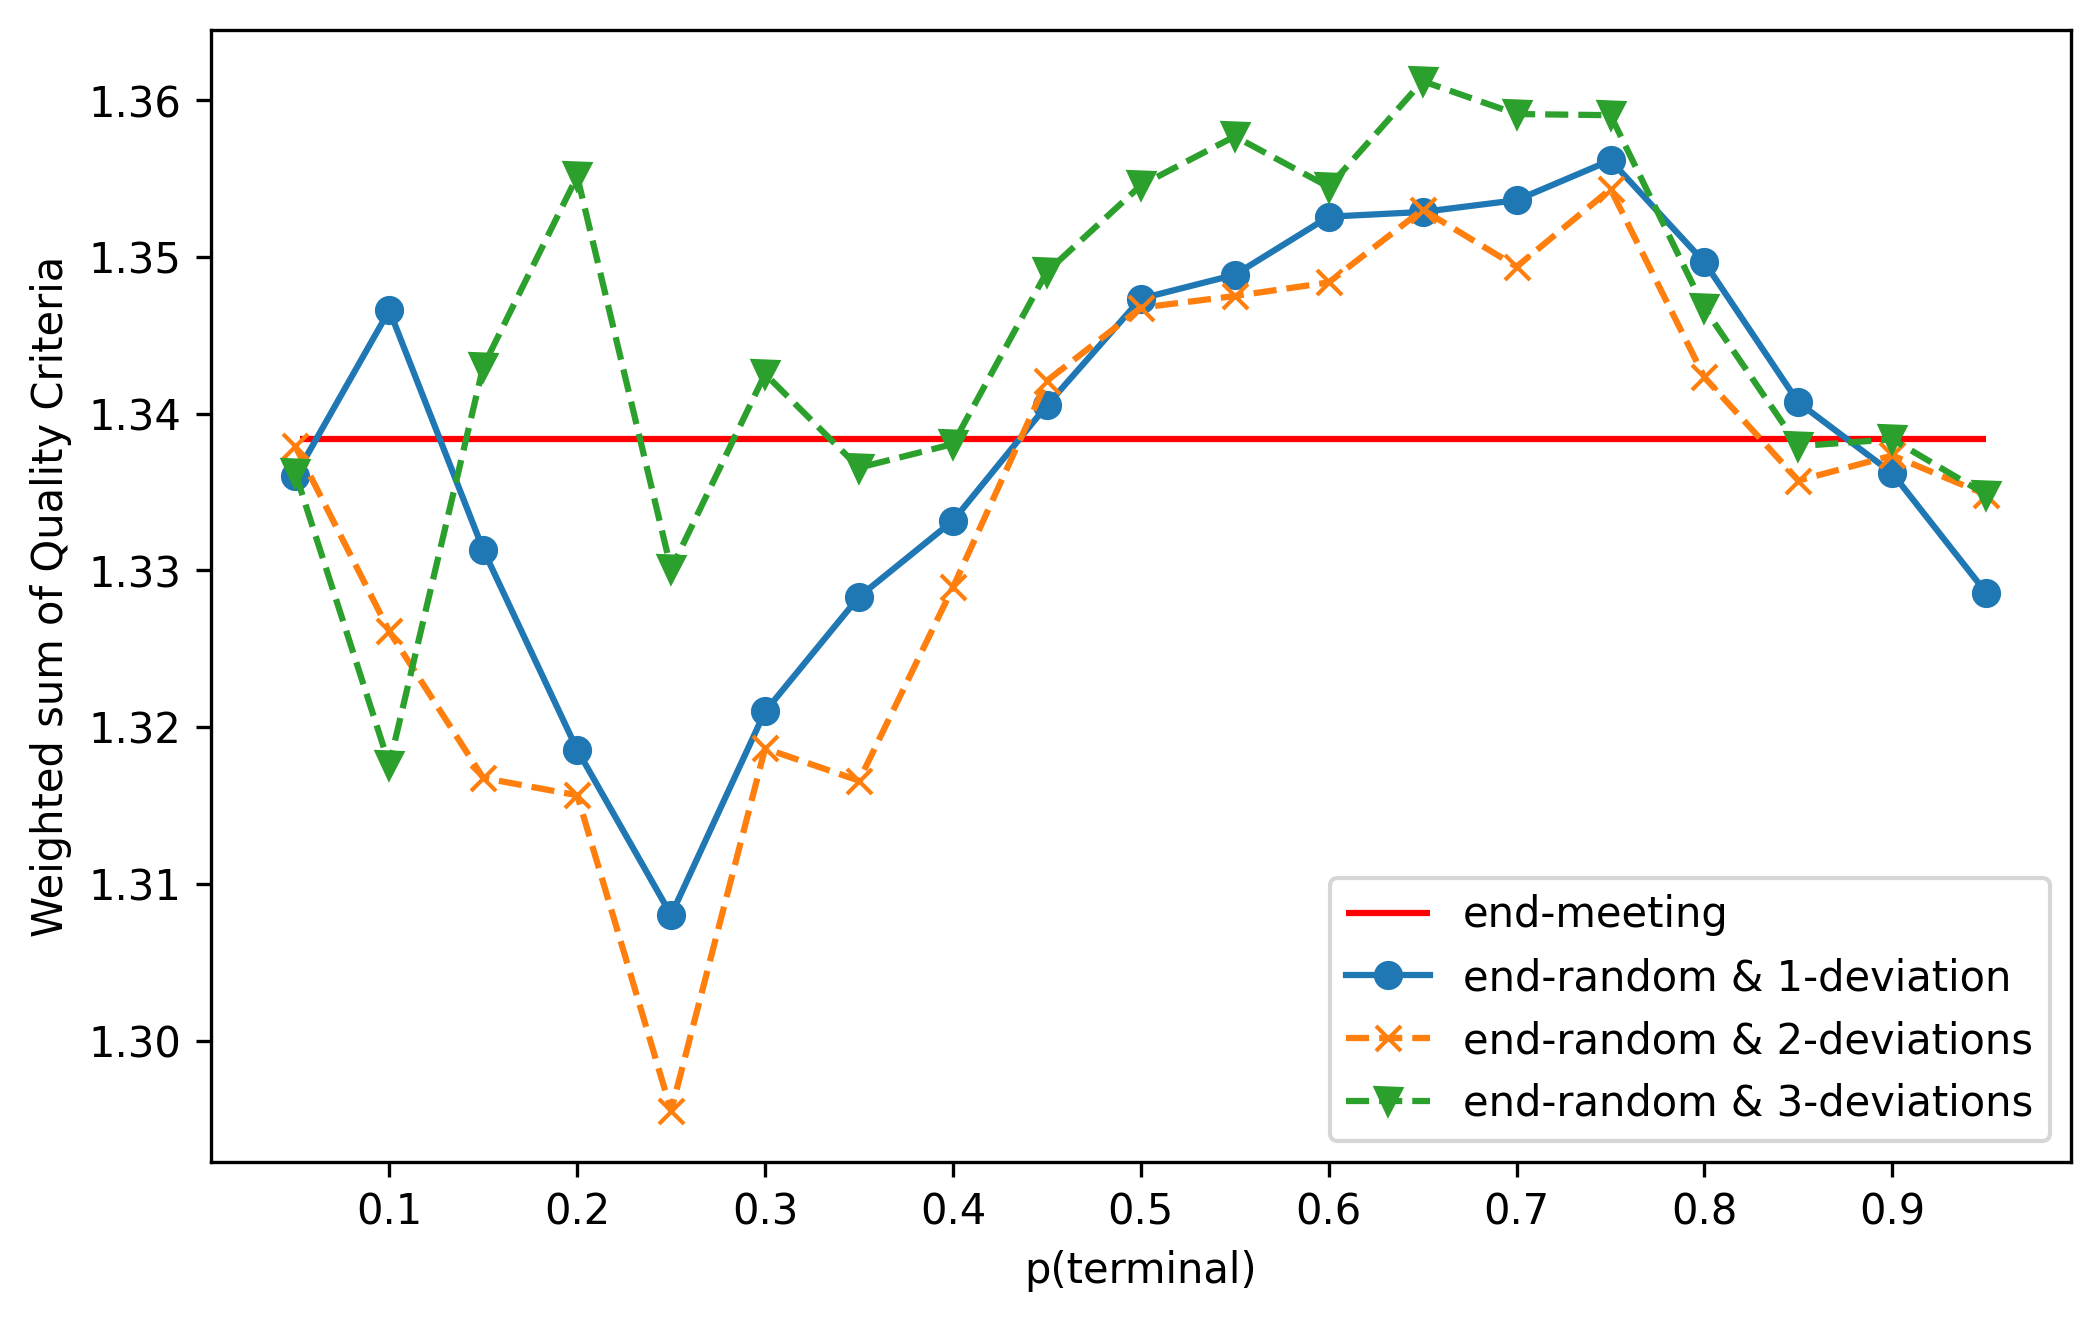

In [98]:
x = ['0.05', '0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95']
x_m = 'meeting'

y = [means['a_ending_prob'+i] if i != '0.2' else means['a'] for i in x]
y_std = [stds['a_ending_prob'+i] if i != '0.2' else stds['a'] for i in x]
y_upper_quartile = [np.quantile(qcs_all['a_ending_prob'+i], 0.75) if i != '0.2' else np.quantile(qcs_all['a'], 0.75) for i in x]
y_lower_quartile = [np.quantile(qcs_all['a_ending_prob'+i], 0.25) if i != '0.2' else np.quantile(qcs_all['a'], 0.25) for i in x]
y_2 = [means['a_ending_prob'+i+'_num_deviations2'] if i != '0.2' else means['a_num_deviations2'] for i in x]
y_2_std = [stds['a_ending_prob'+i+'_num_deviations2'] if i != '0.2' else stds['a_num_deviations2'] for i in x]
y_2_upper_quartile = [np.quantile(qcs_all['a_ending_prob'+i+'_num_deviations2'], 0.75) if i != '0.2' else np.quantile(qcs_all['a_num_deviations2'], 0.75) for i in x]
y_2_lower_quartile = [np.quantile(qcs_all['a_ending_prob'+i+'_num_deviations2'], 0.25) if i != '0.2' else np.quantile(qcs_all['a_num_deviations2'], 0.25) for i in x]
y_3 = [means['a_ending_prob'+i+'_num_deviations3'] if i != '0.2' else means['a_num_deviations3'] for i in x]
y_3_std = [stds['a_ending_prob'+i+'_num_deviations3'] if i != '0.2' else stds['a_num_deviations3'] for i in x]
y_3_upper_quartile = [np.quantile(qcs_all['a_ending_prob'+i+'_num_deviations3'], 0.75) if i != '0.2' else np.quantile(qcs_all['a_num_deviations3'], 0.75) for i in x]
y_3_lower_quartile = [np.quantile(qcs_all['a_ending_prob'+i+'_num_deviations3'], 0.25) if i != '0.2' else np.quantile(qcs_all['a_num_deviations3'], 0.25) for i in x]
# y_6 = [means['a_ending_prob'+i+'_num_deviations6'] if i != '0.2' else means['a_num_deviations6'] for i in x]
# y_6_std = [stds['a_ending_prob'+i+'_num_deviations6'] if i != '0.2' else stds['a_num_deviations6'] for i in x]

y_m = means['a_ending_meeting1']
y_m_std = stds['a_ending_meeting1']
y_m_upper_quartile = np.quantile(qcs_all['a_ending_meeting1'], 0.75)
y_m_lower_quartile = np.quantile(qcs_all['a_ending_meeting1'], 0.25)

plt.figure(figsize=(8, 5), dpi=300)
plt.hlines(y=y_m, xmin=0.05, xmax=18.0, color='r', linestyle='-', label='end-meeting')
plt.plot(x, y, '-o', label='end-random & 1-deviation')
plt.plot(x, y_2, '--x', label='end-random & 2-deviations')
plt.plot(x, y_3, '--v', label='end-random & 3-deviations')
# plt.plot(x, y_6, '--^', label='end-random & 6-deviations')
# plt.fill_between(x, y_lower_quartile, y_upper_quartile, color='b', alpha=.1)
# plt.fill_between(x, y_2_lower_quartile, y_2_upper_quartile, color='yellow', alpha=.1)
# plt.fill_between(x, y_3_lower_quartile, y_3_upper_quartile, color='green', alpha=.1)
# plt.fill_between(x, y_m_lower_quartile, y_m_upper_quartile, color='r', alpha=.1)


# Get x ticks
x_ticks = np.arange(1, len(x), 2)

# Set x ticks 
plt.xticks(x_ticks, [x[i] for i in x_ticks])
plt.ylabel('Weighted sum of Quality Criteria')
plt.xlabel('p(terminal)')
# plt.title('Quality Criteria achieved by different methods of ending the CTE.')
plt.legend()
plt.show()

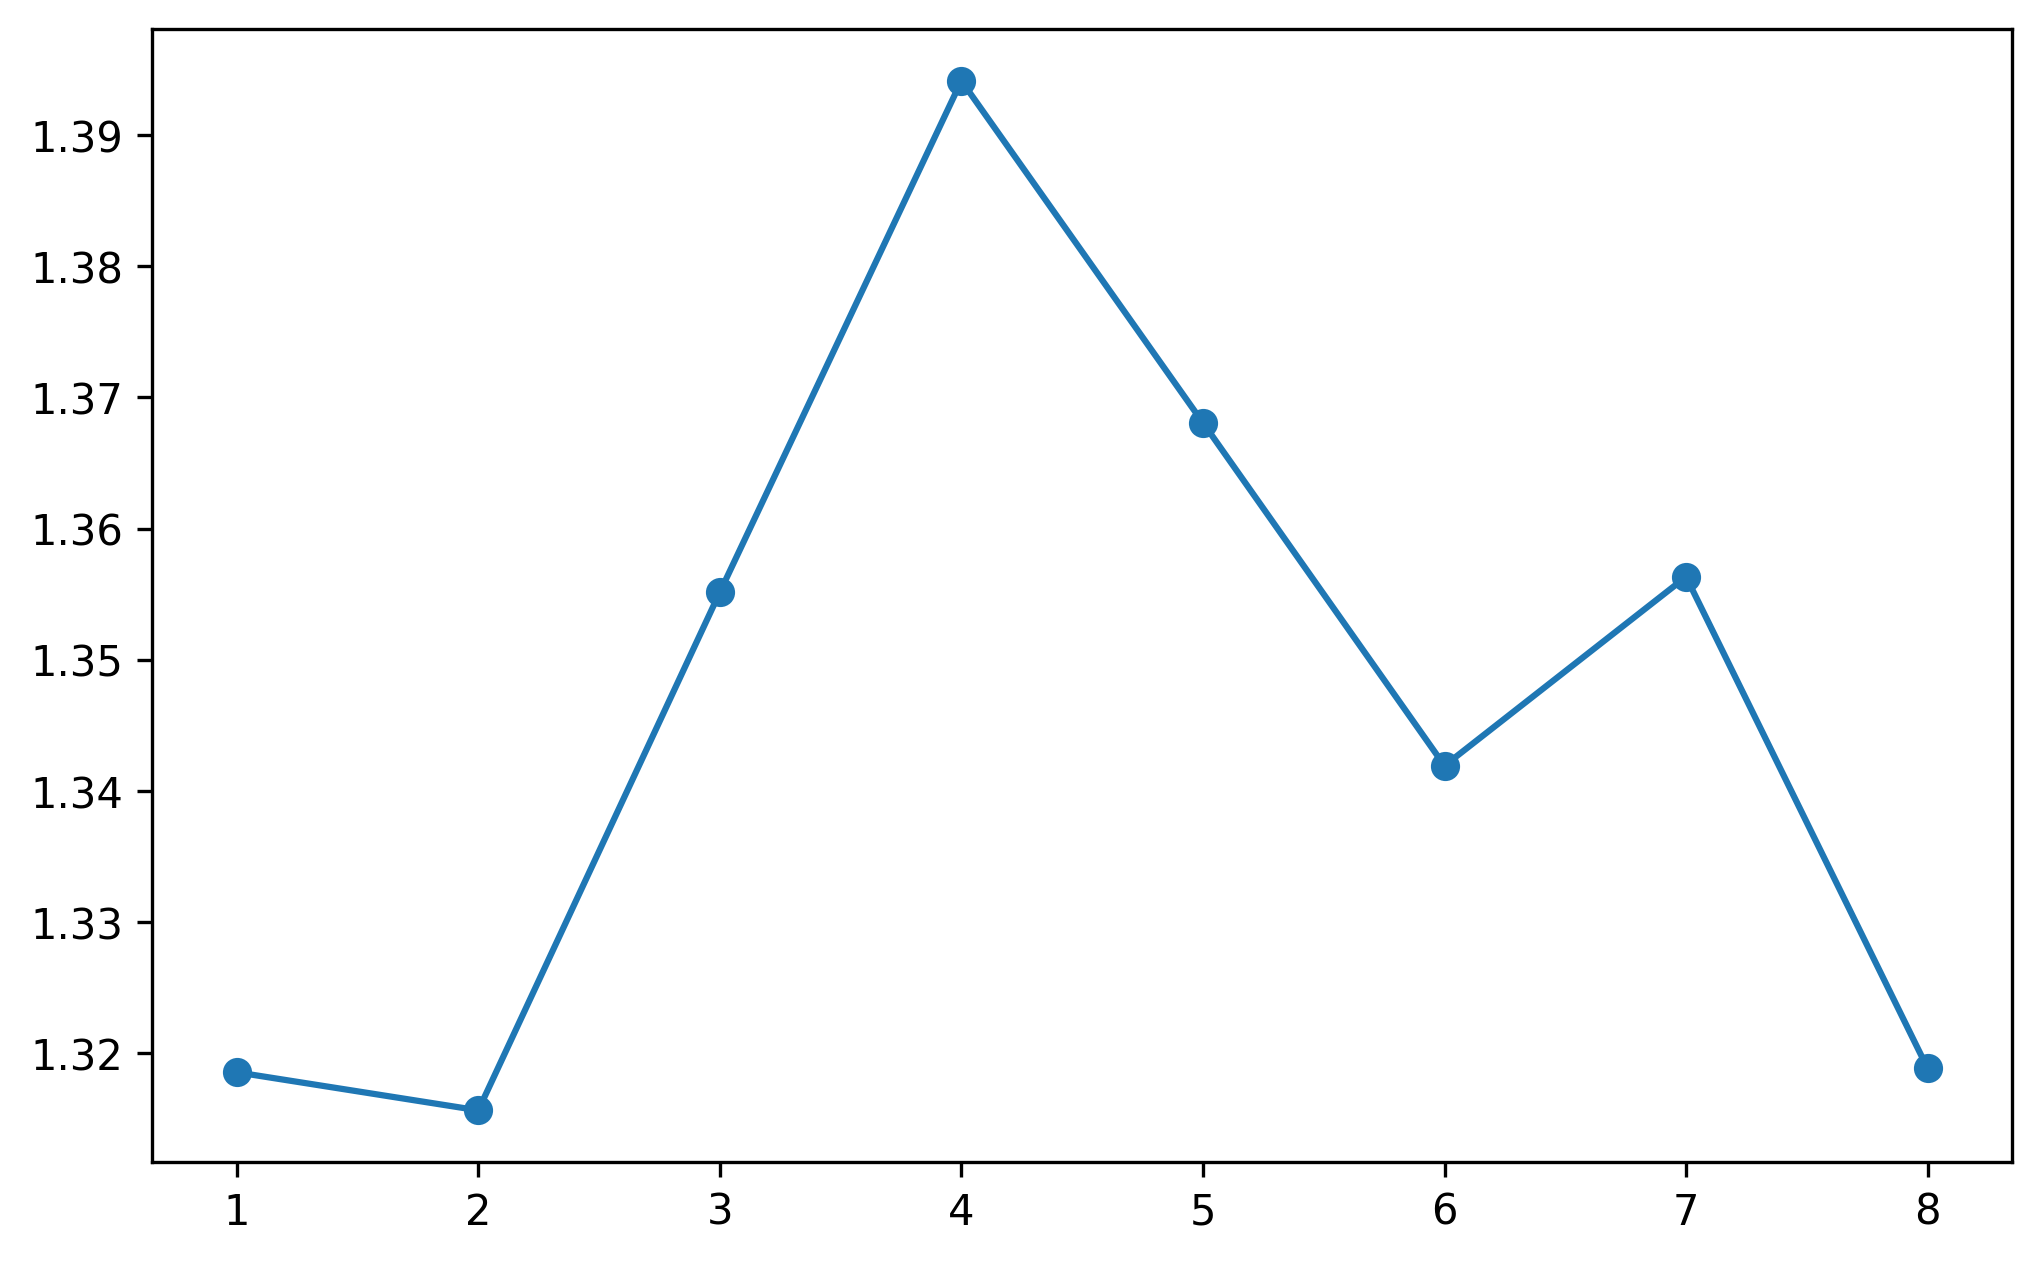

In [90]:
# plot the number of deviations
x = ['1', '2', '3', '4', '5', '6', '7', '8']
y = [means['a_num_deviations'+i] if i != '1' else means['a'] for i in x]
y_std = [stds['a_num_deviations'+i] if i != '1' else stds['a'] for i in x]

plt.figure(figsize=(8, 5), dpi=300)
plt.plot(x, y, '-o')
plt.show()

In [ ]:
table = [
    ['', 'qc-sum'],
    ['1 deviation \& follow policy', means['a']],
    ['2 deviations \& follow policy', means['a_num_deviations2']],
    ['random actions', means['a_follow_policy0']],
]

print(tabulate(table, headers='firstrow', tablefmt='latex'))

\begin{tabular}{lr}
\hline
                &   qc-sum \\
\hline
 1 deviation    &  1.39053 \\
 2 deviations   &  1.45481 \\
 3 deviations   &  1.47257 \\
 4 deviations   &  1.50921 \\
 random actions &  1.08996 \\
\hline
\end{tabular}


### Interpretation

Taking 2 deviations is a clear improvement.

Ending at a random point (instead of requiring to meet) is also strictly better. p(terminal)=0.25 scores the highest

Following the policy is very beneficial

### Further

It would be interesting to see
1. Higher values for p(terminal)
2. How well the combination of 2-deviations and p(terminal) $\in$ {0.15, 0.2, 0.25, 0.3, 0.35} works
3. How well 3 deviations would work